In [31]:
import pandas as pd
import time
import datetime
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

In [45]:
df = pd.read_csv("training_set_VU_DM.csv")
#df = pd.read_csv("sample_training_set.csv")

# Get a sample from the training dataset
#df = df.sample(n=500000)
#df.to_csv('sample_training_set.csv')

## Notes
- There are multiple search results for the same search id
- No. unique id's in the full training set is 199795, 175188 in the sample set
- Position, click_bool , booking_bool and gross_booking_usd is not included in test set! 

## Descriptive dataframe

In [46]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,312,4706481,251866,float64,5.0,1.41
visitor_hist_adr_usd,7799,4705359,252988,float64,1958.7,0.0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,7364,4950983,float64,5.0,0.0


## Split numeric and categoric variables roughly , plot them

In [47]:
descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
descr3.remove('date_time')
descr3.remove('srch_id')
#df.boxplot(column=descr3, figsize=(16, 20))



array([[<AxesSubplot:title={'center':'prop_starrating'}>,
        <AxesSubplot:title={'center':'prop_review_score'}>,
        <AxesSubplot:title={'center':'prop_brand_bool'}>,
        <AxesSubplot:title={'center':'promotion_flag'}>,
        <AxesSubplot:title={'center':'srch_adults_count'}>],
       [<AxesSubplot:title={'center':'srch_children_count'}>,
        <AxesSubplot:title={'center':'srch_room_count'}>,
        <AxesSubplot:title={'center':'srch_saturday_night_bool'}>,
        <AxesSubplot:title={'center':'random_bool'}>,
        <AxesSubplot:title={'center':'comp1_rate'}>],
       [<AxesSubplot:title={'center':'comp1_inv'}>,
        <AxesSubplot:title={'center':'comp2_rate'}>,
        <AxesSubplot:title={'center':'comp2_inv'}>,
        <AxesSubplot:title={'center':'comp3_rate'}>,
        <AxesSubplot:title={'center':'comp3_inv'}>],
       [<AxesSubplot:title={'center':'comp4_rate'}>,
        <AxesSubplot:title={'center':'comp4_inv'}>,
        <AxesSubplot:title={'center':'comp5

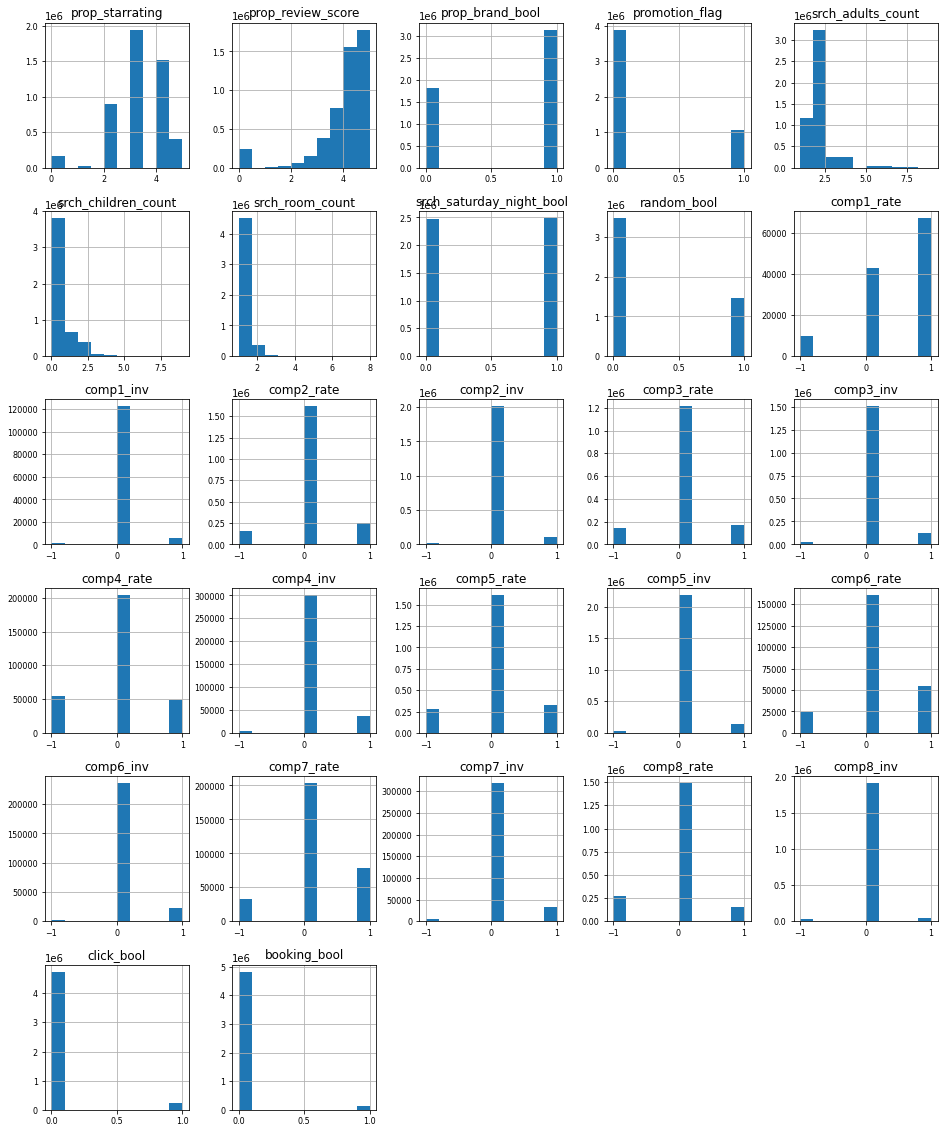

In [48]:
df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

<AxesSubplot:xlabel='date'>

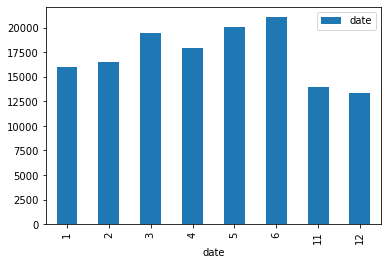

In [49]:
## Check if there is some relation between date time and booking

#split date time in date and time
df[['date', 'time']] = df['date_time'].str.split(' ', 1, expand=True)
df['date'] = pd.to_datetime(df['date'])

# Show booked items and in which month they occurred
df_only_booked = df[df['booking_bool']==1]
df_only_booked = df_only_booked[['date']]
df_only_booked.groupby(df_only_booked["date"].dt.month).count().plot(kind="bar", stacked=True)


<AxesSubplot:>

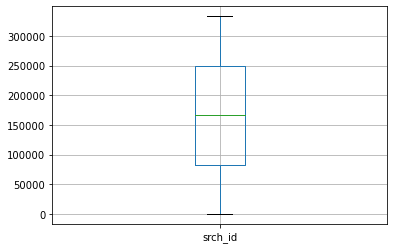

In [50]:
df.boxplot(column = 'srch_id')

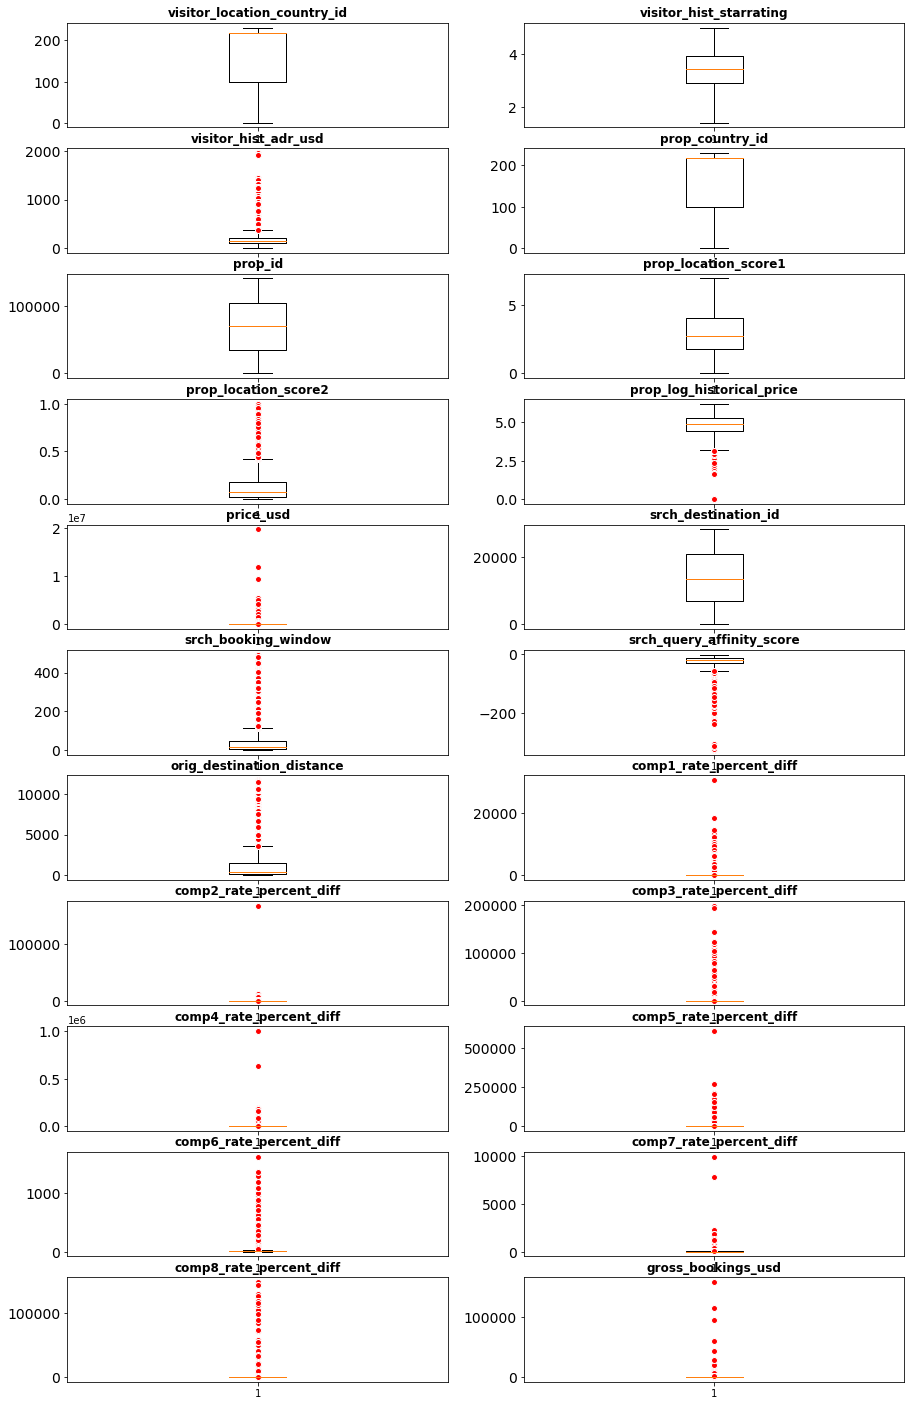

In [51]:
df_numerical = df[descr3]

red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

fig, axs = plt.subplots(11, 2, figsize=(15,25))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle)
    ax.set_title(df_numerical.columns[i], fontweight = 'bold')
    ax.tick_params(axis = 'y', labelsize = 14)

plt.show()

# To do - ?
- Count the amount of clicks per property and plot
- Fill in missing values (are a lot)
- Identify multiple searches of 1 user on 1 property?
- Explore if further data transformation is necessary - how to deal with sparse data
- For modelling: group by user and make ranking

In [52]:
# Show top 5 occuring properties
df2 = df.groupby('prop_id').count()
df2 = df2.sort_values(['srch_id'],ascending=False).head()
print(df2['srch_id'])

# Show top 5 booked properties
df_top5_prop = df.groupby('prop_id').agg({'booking_bool': sum})
df_top5_prop = df_top5_prop.sort_values(['booking_bool'],ascending=False).head()
df_top5_prop

prop_id
104517    2357
124342    2355
68420     2285
40279     2275
134154    2257
Name: srch_id, dtype: int64


,booking_bool
prop_id,
116942,159
22578,140
77089,122
53494,117
137997,109


<ipython-input-53-d03cd1cd9389>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['booking_bool'] = df['booking_bool'].values


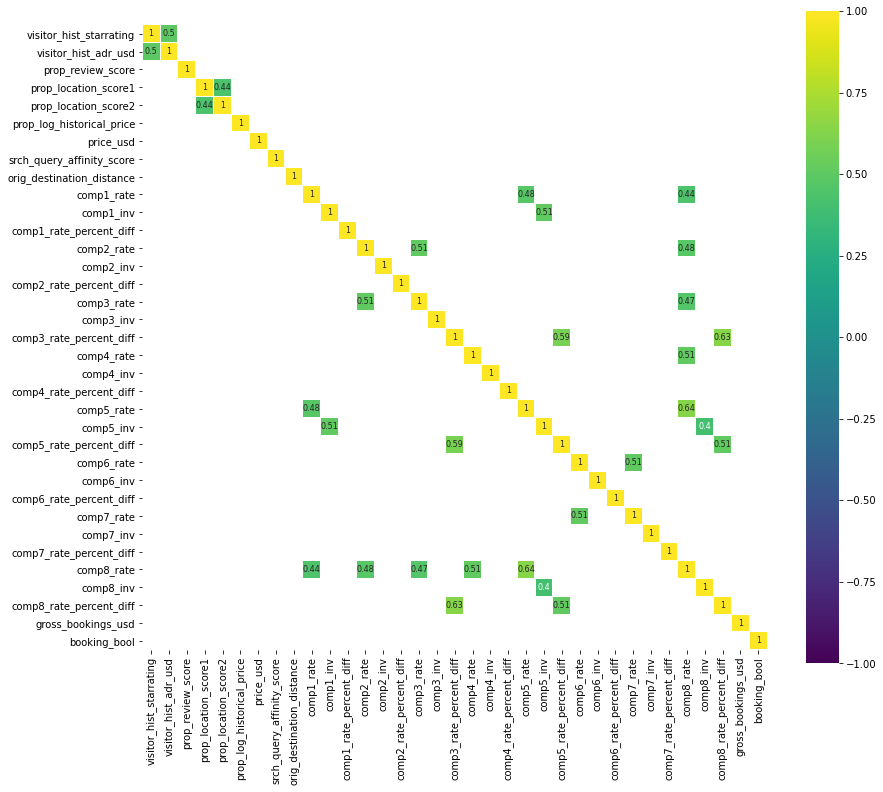

In [53]:
# Plot correlation matrix of all float values + booking or not
df_num = df.select_dtypes(include=[float])
df_num['booking_bool'] = df['booking_bool'].values
corr = df_num.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);


In [18]:
#df = pd.read_csv("test_set_VU_DM.csv")
#df

## Already try some model, doesnt work (yet)
#### See https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [19]:
# Drop date time to not get an error for xgboost
#df.drop('date_time', inplace=True, axis=1)


gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(df, groups=df['srch_id'])

X_train_inds, X_test_inds = next(gss)

train_data= df.iloc[X_train_inds]
test_data= df.iloc[X_test_inds]



groups = train_data.groupby('srch_id').size().to_frame('size')['size'].to_numpy()


X_train = train_data.loc[:, ~train_data.columns.isin(['prop_id','booking_bool'])]
y_train = train_data.loc[:, train_data.columns.isin(['booking_bool'])]

X_test = test_data.loc[:, ~test_data.columns.isin(['booking_bool'])]
y_test = test_data.loc[:, test_data.columns.isin(['booking_bool'])]

print(X_test.shape, y_test.shape)


model = xgb.XGBRanker(
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42, 
    learning_rate=0.1,
    colsample_bytree=0.9, 
    eta=0.05, 
    max_depth=6, 
    n_estimators=110, 
    subsample=0.75 
    )

model.fit(X_train, y_train, group=groups, verbose=True)

def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['prop_id'])])

print('model fitted')
  
predictions = (X_test.groupby('srch_id')
               .apply(lambda x: predict(model, x)))

print('predictions done')
predictions



(199841, 54) (199841, 1)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:date_time